<div style="
  background-color:#0F172A;
  border-left:8px solid #8B5CF6;
  padding:20px;
  border-radius:8px;
  color:#E2E8F0;
">

# 🧪 The Retrieval Laboratory: Dense vs. Multi-Vector Architectures

**Objective:** Conduct a performance comparison of several dense and multi-vector retrieval methods. We will benchmark them against a dataset containing a variety of queries to understand their relative strengths and weaknesses.

**The Contenders:**
1.  **Dense (Edge):** `all-MiniLM-L6-v2` (Fast & Cheap)
2.  **Dense (SOTA):** `bge-large-en-v1.5` (High Performance Open Source)
3.  **Dense (API):** `openai/text-embedding-3-small` (Industry Standard)
4.  **Multi-Vector:** `ColBERTv2` (Late Interaction / MaxSim)

**The Optimizations:**
*   **Scalar & Binary Quantization:** Reducing Memory Cost.
*   **MUVERA:** Compressing Multi-Vectors for HNSW speed.

</div>

In [ ]:
# === 1. Core Libraries ===
import os
import time
import warnings
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from typing import Any
from dataclasses import dataclass

# === 2. Retrieval & AI Libraries ===
from qdrant_client import QdrantClient, models
from fastembed import TextEmbedding, LateInteractionTextEmbedding
from fastembed.postprocess.muvera import Muvera
import openai

# === 3. Visualization Libraries ===
import seaborn as sns
import matplotlib.pyplot as plt

# === 4. Global Configuration ===
# Load environment variables from .env file (e.g., for OPENAI_API_KEY)
load_dotenv()

# Suppress general warnings for cleaner output
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.max_rows', 100)

# === 5. Constants ===
# Data is located relative to the notebook location (in 'tutorial/data')
DATA_DIR: str = "data"
# Storing Qdrant data on disk to prevent RAM overload during heavy indexing
QDRANT_PATH: str = "./qdrant_data"

print("✅ Environment configured.")

✅ Environment configured.


## 1️⃣ Data Loading & Inspection

In [3]:
# Load the datasets generated in the previous step
try:
    df_kb = pd.read_csv(os.path.join(DATA_DIR, "policy_faq.csv"))
    df_eval = pd.read_csv(os.path.join(DATA_DIR, "evaluation_set.csv"))

    # Ensure the 'is_relevant' column is treated as a boolean for filtering
    df_eval['is_relevant'] = df_eval['is_relevant'].astype(bool)

    print(f"📂 Knowledge Base: {len(df_kb)} documents loaded.")
    print(f"📂 Evaluation Set: {len(df_eval)} queries loaded.")

    # Show distribution of query types (Negation, Numeric, etc.)
    print("\n📊 Difficulty Distribution:")
    print(df_eval['difficulty'].value_counts())

except FileNotFoundError:
    print("❌ Error: Data files not found. Please ensure the data directory is populated.")

📂 Knowledge Base: 50 documents loaded.
📂 Evaluation Set: 110 queries loaded.

📊 Difficulty Distribution:
difficulty
Hard Distractor                14
Distractor                     12
Hard (Negation)                 8
Medium (Negation)               5
Easy (Numeric)                  5
Easy                            5
Medium (Inference)              5
Medium (Specific Entity)        4
Medium (Paraphrase)             4
Hard (Specific Entity)          4
Medium (Condition)              4
Hard (Numeric Threshold)        4
Hard (Exclusion)                3
Medium (Numeric)                3
Hard (Inference)                3
Medium (Numeric Condition)      2
Hard (Numeric Calculation)      2
Hard (Specific Detail)          2
Easy (Paraphrase)               2
Medium (Temporal)               2
Hard (Role Exclusion)           1
Hard (Numeric Boundary)         1
Easy (Temporal)                 1
Hard (Multi-step Numeric)       1
Hard (Numeric Inference)        1
Medium (Numeric Logic)          1


## 2️⃣ Infrastructure: The Vector Store

In [4]:
class VectorStore:
    """A wrapper for Qdrant to manage multiple retrieval architectures."""
    def __init__(self) -> None:
        # Initialize Qdrant on disk to persist data and save RAM
        self.client = QdrantClient(path=QDRANT_PATH)

    def _should_create(self, name: str, check_dimension: int | None = None) -> bool:
        """Determines if a collection should be created or reused.

        Args:
            name: Collection name.
            check_dimension: If provided, verifies that the existing collection
                             matches this dimension. Used for dense vectors where
                             parameters might change (e.g., Muvera).
        """
        if self.client.collection_exists(name):
            # If a dimension is provided, ensure data consistency by verifying match.
            if check_dimension is not None:
                coll_info = self.client.get_collection(name)
                current_dim = coll_info.config.params.vectors.size
                if current_dim != check_dimension:
                    print(f"⚠️ Collection '{name}' dimension mismatch ({current_dim} vs {check_dimension}). Recreating...")
                    return True

            if self.client.count(name).count > 0:
                print(f"⏩ Collection '{name}' exists. Skipping index.")
                return False

        return True

    def create_dense_collection(self, name: str, size: int) -> bool:
        """Creates a standard collection for Dense Vectors (Cosine Similarity)."""
        # Enforce dimension check for dense collections to handle parameter changes (e.g. Muvera)
        if not self._should_create(name, check_dimension=size): return False

        self.client.recreate_collection(
            collection_name=name,
            vectors_config=models.VectorParams(size=size, distance=models.Distance.COSINE)
        )
        print(f"✅ Created Dense Collection: '{name}'")
        return True

    def create_colbert_collection(self, name: str, size: int, quantization_type: str | None = None) -> bool:
        """Creates a collection for Multi-Vectors, with optional quantization."""
        # ColBERT dimensions are fixed by the model architecture, so strict dimension checking is unnecessary.
        if not self._should_create(name, check_dimension=None): return False

        # Configure compression (Quantization) if requested
        quant_config: models.QuantizationConfig | None = None
        if quantization_type == "scalar":
            quant_config = models.ScalarQuantization(
                scalar=models.ScalarQuantizationConfig(type=models.ScalarType.INT8, quantile=0.99, always_ram=True)
            )
        elif quantization_type == "binary":
            quant_config = models.BinaryQuantization(
                binary=models.BinaryQuantizationConfig(always_ram=True)
            )

        self.client.recreate_collection(
            collection_name=name,
            vectors_config=models.VectorParams(
                size=size,
                distance=models.Distance.COSINE,
                multivector_config=models.MultiVectorConfig(comparator=models.MultiVectorComparator.MAX_SIM),
                quantization_config=quant_config,
                on_disk=True
            )
        )
        print(f"✅ Created Multi-Vector Collection: '{name}' (Quant: {quantization_type})")
        return True

    def index_points(self, name: str, points: list[models.PointStruct]) -> None:
        """Uploads a batch of points to the specified Qdrant collection."""
        self.client.upload_points(collection_name=name, points=points, wait=True)
        print(f"📥 Indexed {len(points)} documents into '{name}'")

store = VectorStore()

## 3️⃣ Initializing Models

In [ ]:
print("⏳ Loading Models... (This may take a moment)")

# --- 1. Dense Models (Bi-Encoders via FastEmbed) ---
dense_models: dict[str, TextEmbedding] = {
    "MiniLM": TextEmbedding("sentence-transformers/all-MiniLM-L6-v2"),
    "BGE-Large": TextEmbedding("BAAI/bge-large-en-v1.5")
}

# --- 2. Multi-Vector Model (ColBERTv2 via FastEmbed) ---
mv_model: LateInteractionTextEmbedding = LateInteractionTextEmbedding("colbert-ir/colbertv2.0")

# --- 3. OpenAI API Wrapper ---
class OpenAIEmbedder:
    """A wrapper to handle OpenAI API calls and errors gracefully."""
    def __init__(self) -> None:
        self.client = openai.OpenAI()

    def embed(self, texts: list[str]) -> list[list[float]] | None:
        try:
            resp = self.client.embeddings.create(input=texts, model="text-embedding-3-small")
            return [d.embedding for d in resp.data]
        except Exception as e:
            print(f"OpenAI API Error: {e}")
            return None

    def query_embed(self, text: str) -> list[float] | None:
        res = self.embed([text])
        return res[0] if res else None

try:
    openai_model = OpenAIEmbedder()
    if openai_model.embed(["test"]):
        print("✅ OpenAI Model initialized")
    else:
        print("⚠️ OpenAI API Key invalid or missing.")
        openai_model = None
except Exception as e:
    print(f"⚠️ OpenAI Model skipped: {e}")
    openai_model = None

print("✅ All Local Models Loaded.")

## 4️⃣ Indexing

In [6]:
documents: list[str] = df_kb['answer'].tolist()
metadata: list[dict[str, Any]] = df_kb.to_dict('records')

# --- 1. Dense (MiniLM) ---
if store.create_dense_collection("idx_minilm", 384):
    emb = list(dense_models['MiniLM'].embed(documents))
    points = [models.PointStruct(id=i, vector=v.tolist(), payload=m) for i, (v, m) in enumerate(zip(emb, metadata))]
    store.index_points("idx_minilm", points)

# --- 2. Dense (BGE-Large) ---
if store.create_dense_collection("idx_bge", 1024):
    emb = list(dense_models['BGE-Large'].embed(documents))
    points = [models.PointStruct(id=i, vector=v.tolist(), payload=m) for i, (v, m) in enumerate(zip(emb, metadata))]
    store.index_points("idx_bge", points)

# --- 3. Dense (OpenAI) ---
if openai_model and store.create_dense_collection("idx_openai", 1536):
    emb = openai_model.embed(documents)
    if emb:
        points = [models.PointStruct(id=i, vector=v, payload=m) for i, (v, m) in enumerate(zip(emb, metadata))]
        store.index_points("idx_openai", points)

# --- 4. Multi-Vector (ColBERT) ---
# We keep 'emb_colbert' in memory to use later in optimization steps without re-calculating.
if store.create_colbert_collection("idx_colbert", 128):
    emb_colbert = [v.tolist() for v in list(mv_model.embed(documents))]
    points = [models.PointStruct(id=i, vector=v, payload=m) for i, (v, m) in enumerate(zip(emb_colbert, metadata))]
    store.index_points("idx_colbert", points)
else:
    # If the collection already exists, reload embeddings for subsequent steps.
    print("♻️  Reloading ColBERT embeddings for optimization steps...")
    emb_colbert = [v.tolist() for v in list(mv_model.embed(documents))]

print("\n✅ Indexing complete.")

✅ Created Dense Collection: 'idx_minilm'
📥 Indexed 50 documents into 'idx_minilm'
✅ Created Dense Collection: 'idx_bge'
📥 Indexed 50 documents into 'idx_bge'
✅ Created Dense Collection: 'idx_openai'
📥 Indexed 50 documents into 'idx_openai'
✅ Created Multi-Vector Collection: 'idx_colbert' (Quant: None)
📥 Indexed 50 documents into 'idx_colbert'

✅ Indexing complete.


## 5️⃣ Evaluation Engine

In [7]:
@dataclass
class EvalMetric:
    """Holds the summary statistics for a model's performance."""
    model_name: str
    accuracy: float
    avg_latency: float
    correct_count: int

class Evaluator:
    """A consistent harness to run the evaluation dataset against any retrieval function."""
    def __init__(self, test_df: pd.DataFrame, faq_df: pd.DataFrame) -> None:
        self.test_df = test_df
        self.faq_df = faq_df
        # Create a mapping from document ID to its text for efficient lookups
        self.id_to_answer = pd.Series(faq_df.answer.values, index=faq_df.id).to_dict()

    def run(self, name: str, search_fn: Any) -> tuple[EvalMetric, pd.DataFrame]:
        """Runs the evaluation and returns both summary metrics and detailed results."""
        latencies: list[float] = []
        results: list[dict[str, Any]] = []
        eval_set = self.test_df[self.test_df['is_relevant'] == True].copy()

        for i, row in eval_set.iterrows():
            start_time = time.time()
            retrieved_id = -1
            retrieved_answer = "Error: No result"
            is_correct = False

            try:
                best_match: dict[str, Any] | None = search_fn(row['question'])
                latency = time.time() - start_time
                latencies.append(latency)

                if best_match:
                    retrieved_answer = best_match['answer']
                    retrieved_id = best_match['id']
                    expected_answer = self.id_to_answer.get(row['src_id'])

                    if retrieved_answer == expected_answer:
                        is_correct = True

            except Exception as e:
                print(f"Error on '{name}' for question id {i}: {e}")
                latency = time.time() - start_time
                latencies.append(latency)

            results.append({
                "question": row['question'],
                "difficulty": row['difficulty'],
                "expected_id": row['src_id'],
                "retrieved_id": retrieved_id,
                "is_correct": is_correct,
                "latency_ms": latency * 1000
            })

        correct_count = sum(r['is_correct'] for r in results)
        accuracy = correct_count / len(eval_set) if len(eval_set) > 0 else 0
        avg_latency = sum(latencies) / len(latencies) if latencies else 0

        metric = EvalMetric(name, accuracy, avg_latency, correct_count)
        details_df = pd.DataFrame(results)

        return metric, details_df

evaluator = Evaluator(df_eval, df_kb)
print("✅ Evaluator ready.")

✅ Evaluator ready.


## 6️⃣ Benchmarks

In [8]:
results_registry: list[EvalMetric] = []
detailed_results_registry: dict[str, pd.DataFrame] = {}

# --- Search Helpers ---
def search_dense(query: str, model_key: str, coll_name: str) -> dict[str, Any] | None:
    """Encodes a query with a dense model and searches the corresponding collection."""
    if model_key == "OpenAI" and not openai_model: return None

    if model_key == "OpenAI":
        vec = openai_model.query_embed(query)
    else:
        vec = list(dense_models[model_key].embed([query]))[0].tolist()

    if vec is None: return None

    res = store.client.query_points(collection_name=coll_name, query=vec, limit=1).points
    return res[0].payload if res else None

def search_colbert(query: str) -> dict[str, Any] | None:
    """Encodes a query with the ColBERT model and searches the multi-vector collection."""
    vec = next(mv_model.query_embed(query)).tolist()
    res = store.client.query_points(collection_name="idx_colbert", query=vec, limit=1).points
    return res[0].payload if res else None

# --- Run Benchmarks ---
def run_benchmark(model_name: str, search_fn: Any):
    """Helper to run the evaluator and store both summary and detailed results.
    Ensures idempotency by removing existing results for the same model name before appending.
    """
    print(f"🏃 Running: {model_name}...")
    metric, details = evaluator.run(model_name, search_fn)

    # Remove any prior entry for this model to prevent duplicates if cell is re-run
    global results_registry
    results_registry = [r for r in results_registry if r.model_name != model_name]

    results_registry.append(metric)
    detailed_results_registry[model_name] = details

run_benchmark("Dense (MiniLM)", lambda q: search_dense(q, "MiniLM", "idx_minilm"))
run_benchmark("Dense (BGE)", lambda q: search_dense(q, "BGE-Large", "idx_bge"))
if openai_model:
    run_benchmark("Dense (OpenAI)", lambda q: search_dense(q, "OpenAI", "idx_openai"))
run_benchmark("ColBERT (MV)", search_colbert)

print("\n✅ All base benchmarks complete.")

🏃 Running: Dense (MiniLM)...
🏃 Running: Dense (BGE)...
🏃 Running: Dense (OpenAI)...
🏃 Running: ColBERT (MV)...

✅ All base benchmarks complete.


## 7️⃣ Optimizations: Quantization & MUVERA

In [9]:
# --- 1. Quantization Benchmarks ---

def search_colbert_scalar(q: str) -> dict[str, Any] | None:
    vec = next(mv_model.query_embed(q)).tolist()
    res = store.client.query_points(collection_name="idx_colbert_scalar", query=vec, limit=1).points
    return res[0].payload if res else None

def search_colbert_binary(q: str) -> dict[str, Any] | None:
    vec = next(mv_model.query_embed(q)).tolist()
    res = store.client.query_points(collection_name="idx_colbert_binary", query=vec, limit=1).points
    return res[0].payload if res else None

# A. Scalar Quantized ColBERT (INT8)
if store.create_colbert_collection("idx_colbert_scalar", 128, quantization_type="scalar"):
    points = [models.PointStruct(id=i, vector=v, payload=m) for i, (v, m) in enumerate(zip(emb_colbert, metadata))]
    store.index_points("idx_colbert_scalar", points)
run_benchmark("ColBERT (INT8)", search_colbert_scalar)

# B. Binary Quantized ColBERT (1-bit)
if store.create_colbert_collection("idx_colbert_binary", 128, quantization_type="binary"):
    points = [models.PointStruct(id=i, vector=v, payload=m) for i, (v, m) in enumerate(zip(emb_colbert, metadata))]
    store.index_points("idx_colbert_binary", points)
run_benchmark("ColBERT (Binary)", search_colbert_binary)


# --- 2. MUVERA (Algorithmic Compression) ---
def search_muvera(q: str) -> dict[str, Any] | None:
    q_vecs = next(mv_model.query_embed(q))
    q_muv = muvera_proc.process_query(q_vecs).tolist()
    res = store.client.query_points(collection_name="idx_muvera", query=q_muv, limit=1).points
    return res[0].payload if res else None

try:
    print("\n⏳ Initializing MUVERA...")
    # NOTE: To run this successfully after changing parameters, you must delete the
    # ./qdrant_data directory to force a re-index with the new vector dimensions.
    muvera_proc = Muvera(dim=128, k_sim=6, dim_proj=8, r_reps=20)
    # Output dim = 64 clusters * 8 dims * 20 reps = 10240 dimensions.
    muvera_dim = (2**muvera_proc.k_sim) * muvera_proc.dim_proj * muvera_proc.r_reps

    if store.create_dense_collection("idx_muvera", muvera_dim):
        print("⏳ Compressing and Indexing MUVERA...")
        points_muvera = []
        for i, (v, m) in enumerate(zip(emb_colbert, metadata)):
            c_vec = muvera_proc.process_document(np.array(v)).tolist()
            points_muvera.append(models.PointStruct(id=i, vector=c_vec, payload=m))
        store.index_points("idx_muvera", points_muvera)

    run_benchmark("ColBERT (MUVERA)", search_muvera)

except Exception as e:
    print(f"⚠️ MUVERA Skipped/Failed: {e}")

print("\n✅ All optimization benchmarks complete.")

✅ Created Multi-Vector Collection: 'idx_colbert_scalar' (Quant: scalar)
📥 Indexed 50 documents into 'idx_colbert_scalar'
🏃 Running: ColBERT (INT8)...
✅ Created Multi-Vector Collection: 'idx_colbert_binary' (Quant: binary)
📥 Indexed 50 documents into 'idx_colbert_binary'
🏃 Running: ColBERT (Binary)...

⏳ Initializing MUVERA...
✅ Created Dense Collection: 'idx_muvera'
⏳ Compressing and Indexing MUVERA...
📥 Indexed 50 documents into 'idx_muvera'
🏃 Running: ColBERT (MUVERA)...

✅ All optimization benchmarks complete.


## 8️⃣ Final Leaderboard

🏆 FINAL RESULTS 🏆
| Method           |   Accuracy |   Latency (ms) |   Correct |
|:-----------------|-----------:|---------------:|----------:|
| Dense (OpenAI)   |   0.988095 |      260.899   |        83 |
| Dense (MiniLM)   |   0.928571 |        9.14655 |        78 |
| Dense (BGE)      |   0.916667 |      242.061   |        77 |
| ColBERT (INT8)   |   0.904762 |      116.246   |        76 |
| ColBERT (Binary) |   0.904762 |      116.299   |        76 |
| ColBERT (MV)     |   0.904762 |      116.353   |        76 |
| ColBERT (MUVERA) |   0.904762 |      162.925   |        76 |



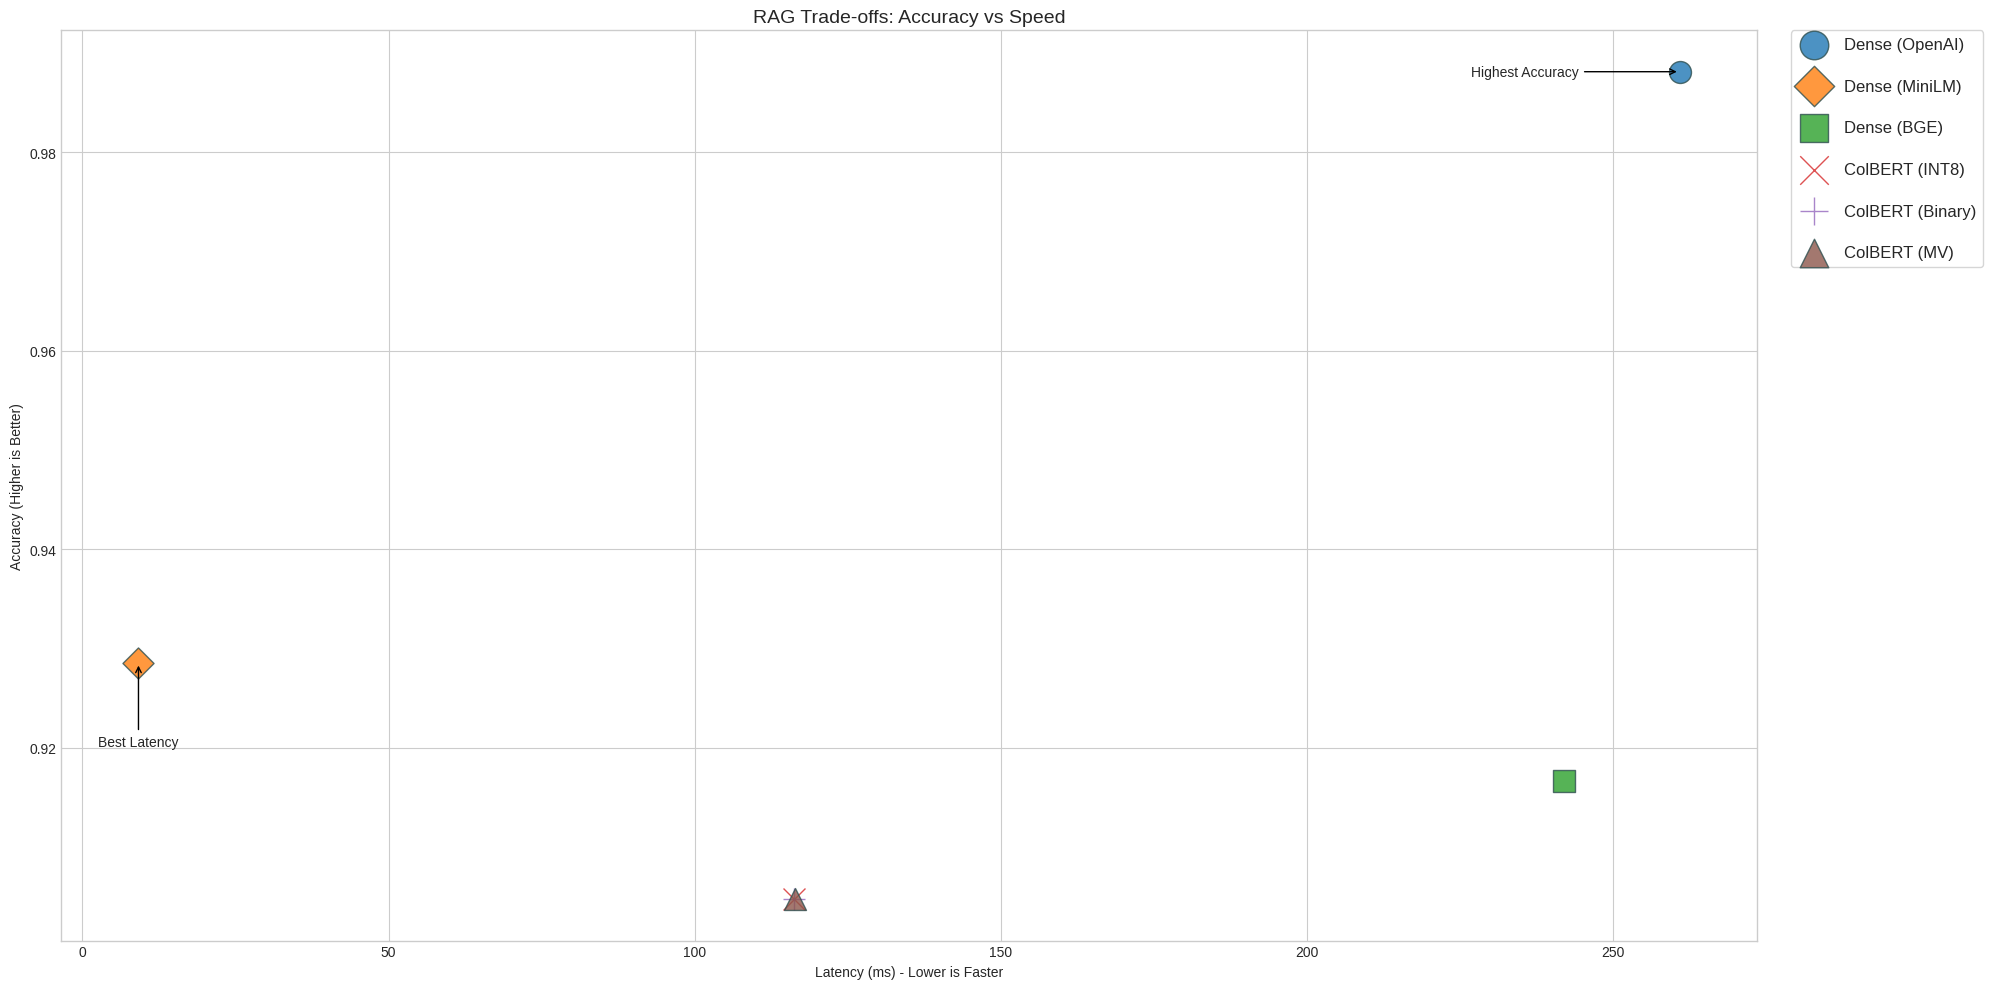

In [ ]:
df_res = pd.DataFrame([
    {
        "Method": r.model_name,
        "Accuracy": r.accuracy,
        "Latency (ms)": r.avg_latency * 1000,
        "Correct": r.correct_count
    }
    for r in results_registry
])

df_res = df_res.sort_values(by=["Accuracy", "Latency (ms)"], ascending=[False, True])

print("🏆 FINAL RESULTS 🏆")
print(" " + "="*60)
print(df_res.to_markdown(index=False))
print(" " + "="*60)
print()

# --- Visualization Setup ---
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(15, 8))

# Define unique markers and colors for distinct model representation
methods = df_res["Method"].unique()
markers = ['o', 'D', 's', 'x', '+', '^']
colors = sns.color_palette("tab10", len(methods))

# Generate scatter plot with distinct styles for each architecture
for method, marker, color in zip(methods, markers, colors):
    subset = df_res[df_res["Method"] == method]
    ax.scatter(
        subset["Latency (ms)"],
        subset["Accuracy"],
        s=250,
        marker=marker,
        color=color,
        edgecolor="darkslategray",
        linewidth=1,
        alpha=0.8,
        label=method
    )

# Configure plot aesthetics and axes
ax.set_title("RAG Trade-offs: Accuracy vs Speed", fontsize=14)
ax.set_xlabel("Latency (ms) - Lower is Faster")
ax.set_ylabel("Accuracy (Higher is Better)")

# Optimize legend visibility and positioning
ax.legend(
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    frameon=True,
    borderaxespad=0,
    fontsize=12,
    labelspacing=1.6,
    handlelength=2.0,
    handletextpad=0.8,
    markerscale=1.3
)

# Highlight key performance metrics (Fastest vs. Most Accurate)
if not df_res.empty:
    min_latency_idx = df_res["Latency (ms)"].idxmin()
    max_accuracy_idx = df_res["Accuracy"].idxmax()

    # Label for Best Latency
    ax.annotate(
        "Best Latency",
        xy=(
            df_res.loc[min_latency_idx, "Latency (ms)"],
            df_res.loc[min_latency_idx, "Accuracy"]
        ),
        xytext=(0, -60),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->"),
        ha="center"
    )

    # Label for Highest Accuracy
    ax.annotate(
        "Highest Accuracy",
        xy=(
            df_res.loc[max_accuracy_idx, "Latency (ms)"],
            df_res.loc[max_accuracy_idx, "Accuracy"]
        ),
        xytext=(-150, 0),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->"),
        va="center"
    )

# Final Layout
plt.tight_layout()
plt.show()

## 9️⃣ Deep-Dive Analysis

The leaderboard gives us the high-level scores, but to truly understand model behavior, we need to look deeper. This section aggregates all the detailed, per-question results into a single DataFrame. We will use this to analyze performance across different question types and to inspect specific examples of successes and failures.

In [11]:
# Consolidate all detailed results into a single DataFrame for easier analysis
all_details = []
for model_name, df_detail in detailed_results_registry.items():
    df_detail['model_name'] = model_name
    all_details.append(df_detail)

df_analysis = pd.concat(all_details).reset_index(drop=True)

# Add the expected and retrieved answer text for easier qualitative review
id_to_answer_map = df_kb.set_index('id')['answer'].to_dict()
df_analysis['expected_answer'] = df_analysis['expected_id'].map(id_to_answer_map)
df_analysis['retrieved_answer'] = df_analysis['retrieved_id'].map(id_to_answer_map)

print("✅ Analysis DataFrame created with shape:", df_analysis.shape)
df_analysis.head()

✅ Analysis DataFrame created with shape: (588, 9)


,question,difficulty,expected_id,retrieved_id,is_correct,latency_ms,model_name,expected_answer,retrieved_answer
0,Can I use my personal laptop on the Corp-Secure network?,Hard (Negation),0,0,True,15.035391,Dense (MiniLM),Personal devices are allowed on the 'Guest' Wi-Fi network only. Under no circumstances are personal laptops or non-company-issued devices permitte...,Personal devices are allowed on the 'Guest' Wi-Fi network only. Under no circumstances are personal laptops or non-company-issued devices permitte...
1,Is alcohol covered in the travel meal allowance?,Hard (Negation),20,20,True,7.729292,Dense (MiniLM),Employees traveling for business are allocated a per diem of $75 for meals and incidentals. Alcohol is explicitly EXCLUDED from reimbursement and ...,Employees traveling for business are allocated a per diem of $75 for meals and incidentals. Alcohol is explicitly EXCLUDED from reimbursement and ...
2,Does the standard plan cover root canals?,Medium (Specific Entity),10,10,True,7.607460,Dense (MiniLM),"The Standard Health Plan covers routine dental cleanings and fillings. Major dental surgery, such as root canals and crowns, is ONLY covered under...","The Standard Health Plan covers routine dental cleanings and fillings. Major dental surgery, such as root canals and crowns, is ONLY covered under..."
3,"I'm in Sales, can I request a MacBook?",Hard (Role Exclusion),25,25,True,8.825302,Dense (MiniLM),"MacBook Pros are the standard issue for Engineering, Design, and Product Management teams only. All other departments, including Sales, HR, and Fi...","MacBook Pros are the standard issue for Engineering, Design, and Product Management teams only. All other departments, including Sales, HR, and Fi..."
4,"I saved client data on my desktop, is that okay?",Hard (Negation),6,6,True,8.897305,Dense (MiniLM),"Customer PII (Personally Identifiable Information) must NEVER be stored on local laptop drives, personal cloud storage, or Google Drive. It must o...","Customer PII (Personally Identifiable Information) must NEVER be stored on local laptop drives, personal cloud storage, or Google Drive. It must o..."


### 📈 Accuracy by Question Difficulty

This analysis breaks down model performance by the `difficulty` category of each question. The resulting heatmap allows us to quickly identify the strengths and weaknesses of each retrieval strategy. For example, some models may excel at simple paraphrasing but struggle with queries requiring numerical or conditional logic.

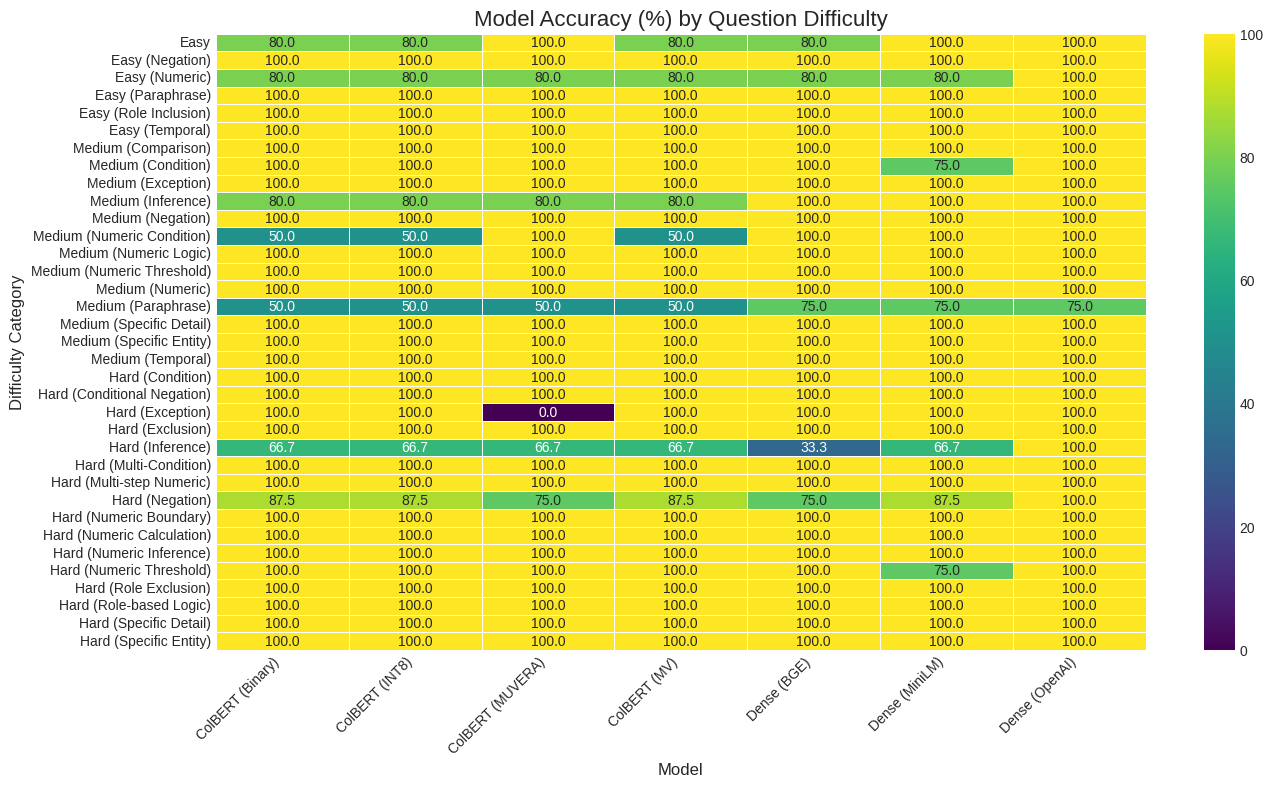

In [ ]:
# Calculate accuracy for each model on each difficulty category
difficulty_accuracy = (
    df_analysis
    .groupby(['model_name', 'difficulty'])['is_correct']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# Extract the accuracy for correct answers (where is_correct=True)
difficulty_accuracy = (
    difficulty_accuracy.get(True, 0) * 100
).reset_index().rename(columns={True: "accuracy_perc"})

# Create a pivot table for easier plotting
pivot_df = difficulty_accuracy.pivot(
    index='difficulty',
    columns='model_name',
    values='accuracy_perc'
)

# --- Reorder the difficulty categories for a more logical display ---
# Define a desired order for the difficulty levels
difficulty_order = ['Easy', 'Medium', 'Hard']
# Filter the existing index to only those present in our desired order
present_difficulties = [d for d in pivot_df.index if d.split(' ')[0] in difficulty_order]
# Sort the present difficulties based on the desired order
sorted_index = sorted(
    present_difficulties,
    key=lambda x: difficulty_order.index(x.split()[0])
)
pivot_df = pivot_df.loc[sorted_index]

# Plotting the results as a heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(pivot_df, annot=True, fmt=".1f", cmap="viridis", linewidths=.5)
plt.title('Model Accuracy (%) by Question Difficulty', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Difficulty Category', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.show()

### ❌ Failure Analysis: Reviewing Incorrect Retrievals

Inspecting the specific questions that a model answered incorrectly is one of the best ways to understand its limitations. This section displays a sample of failed queries for the top-performing models from the leaderboard, allowing for a qualitative review of their failure modes.

In [13]:
# Dynamically select the top N models from the leaderboard for failure analysis
top_models = df_res['Method'].head(3).tolist()

failures = df_analysis[
    (df_analysis['model_name'].isin(top_models)) &
    (df_analysis['is_correct'] == False)
].copy()

# Add a column for the expected and retrieved question titles for context
id_to_question_map = df_kb.set_index('id')['question'].to_dict()
failures['expected_question'] = failures['expected_id'].map(id_to_question_map)
failures['retrieved_question'] = failures['retrieved_id'].map(id_to_question_map)

print(f"Displaying up to 3 failures for each of the top models: {top_models}\n")

for model in top_models:
    model_failures = failures[failures['model_name'] == model]
    if not model_failures.empty:
        print("="*80)
        print(f"MODEL: {model}")
        print("="*80)
        for _, row in model_failures.head(3).iterrows():
            print(f"❓ QUESTION: {row['question']}")
            print(f"    - Difficulty: {row['difficulty']}")
            print(f"    - EXPECTED (ID {row['expected_id']}): {row['expected_question']}")
            print(f"    - RETRIEVED (ID {row['retrieved_id']}): {row['retrieved_question']}")
            print("\n" + "-"*40 + "\n")
    else:
        print(f"✅ No failures recorded for model: {model}")

Displaying up to 3 failures for each of the top models: ['Dense (OpenAI)', 'Dense (MiniLM)', 'Dense (BGE)']

MODEL: Dense (OpenAI)
❓ QUESTION: What is the process after a major system failure?
    - Difficulty: Medium (Paraphrase)
    - EXPECTED (ID 9): What is the on-call incident response protocol?
    - RETRIEVED (ID 4): What is the response time for IT tickets?

----------------------------------------

MODEL: Dense (MiniLM)
❓ QUESTION: Is my daily drive to the office reimbursable?
    - Difficulty: Hard (Negation)
    - EXPECTED (ID 28): Policy on mileage reimbursement for using a personal car?
    - RETRIEVED (ID 33): Can I have personal mail delivered to the office?

----------------------------------------

❓ QUESTION: My friend completed 60 days of their probation, do I get my referral bonus now?
    - Difficulty: Hard (Numeric Threshold)
    - EXPECTED (ID 12): Do I get a bonus for referring a friend?
    - RETRIEVED (ID 17): What is the probation period for new hires?

-----